# Efficiency calibration of detector room 131

The efficiency of the detector is determined for a range of distances on three different calibration sources using data from fits-peaks and nndc. A curve is fitted to the datapoints and stored in arrays. 

## Content
1. Defining functions and values, reading the nndc files and the fitz reports
2. Analysing the ccalibration sources for Cs, Ba and Eu
3. Curve fitting 
4. Final models


In [1]:
import matplotlib
import matplotlib.pyplot as plt  

matplotlib.rcParams['figure.figsize']  = (20.0, 10.0)
matplotlib.rcParams['axes.grid']       = False
matplotlib.rcParams['font.size']       = 15
#matplotlib.rcParams['font.family']     = 'OfficinaSanITCBoo'
matplotlib.rcParams['axes.labelsize']  = 0.9*plt.rcParams['font.size']
matplotlib.rcParams['axes.titlesize']  = 1.2*plt.rcParams['font.size']
matplotlib.rcParams['legend.fontsize'] = plt.rcParams['font.size']
matplotlib.rcParams['xtick.labelsize'] = 0.8*plt.rcParams['font.size']
matplotlib.rcParams['ytick.labelsize'] = 0.8*plt.rcParams['font.size']
matplotlib.rcParams['scatter.marker']  = 'o'
matplotlib.rcParams['axes.titlepad']   = 20 
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'

Defining parameters for the detector efficiency calibration through the use of 3 calibration sources: **Cs137, Ba133 and Eu152**. The **activity A0 and sigma A0** are desicreb on the calibration sources depicted in the file _calibration_samples.jpg_. The **half-life t_half and sigma_t_half** of the calibration sources are found in the [nndc database](https://www.nndc.bnl.gov/nudat2/). The efficiency calibration is derived from the formulae: 
<pre>
</pre>

<center>efficiency $ = \dfrac{\lambda N_c}{A_0I_{gamma}(1-e^{-\lambda t_{live}})e^{-\lambda t_{delay}}}$</center>
<pre>
</pre>


In [2]:
import sys, os
from dateutil import parser
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

mypath                  = "/home/oline/Documents/Berkeley/lbl/Calibration_Reports/"
source_calibration_date = "01/01/2009 12:00:00"

t_half                  = np.array((30.08,10.551,13.517))*365*24*3600 # Cs137, Ba133, Eu152; [s]
sigma_t_half            = np.array((0.09,0.011, 0.014))*365*24*3600   # Cs137, Ba133, Eu152; [s]
A0                      = np.array((38.55,39.89,39.29))*1e3                 # Source activity; Cs,Ba,Eu;      [Bq]
sigma_A0                = 0.3*1e3                                            # Uncertainty in activity sources [Bq]

decay_constant          = np.log(2)/t_half
sigma_decay_constant    =  decay_constant*sigma_t_half/t_half

## 1.1 Intensities from the nndc database

Reading a text file with all energies and intensities of gamma rays from the nndc database for all 3 calibration sources. This list is a direct copy of the nndc list of all gamma rays assosiated with the ground level of each calibration element. No Isomer is included. 

In [3]:
def read_intensities(datafile):
    """ Reads list of intensities and energies from the nndc database
    """
    Ba_E, Ba_I, Ba_I_unc = [], [], []                         # KeV, # %
    Cs_E, Cs_I, Cs_I_unc = [], [], []                         # KeV, # %
    Eu_E, Eu_I, Eu_I_unc = [], [], []                         # KeV, # %
    
    with open(datafile, 'r') as infile:
        lines = infile.readlines()
        
        for i in range(6,8):
            Cs_E.append(float(lines[i].split()[0]))
            Cs_I.append(float(lines[i].split()[2]))
            Cs_I_unc.append(float(lines[i].split()[4]))
            
        for i in range(15,24):
            Ba_E.append(float(lines[i].split()[0]))
            Ba_I.append(float(lines[i].split()[2]))
            Ba_I_unc.append(float(lines[i].split()[4]))
            
        for i in range(31,198):
            Eu_E.append(float(lines[i].split()[0]))
            Eu_I.append(float(lines[i].split()[2]))
            Eu_I_unc.append(float(lines[i].split()[4]))
            
    return Ba_E, Ba_I, Ba_I_unc, Cs_E, Cs_I, Cs_I_unc, Eu_E, Eu_I, Eu_I_unc

## 1.2 Reading the Fitz reports to abstract live time and time delay, energy and peak areas

In [4]:
def read_files(path, sample_type, nndc_E, nndc_I, sigma_I, source_calibration_date = source_calibration_date):
    """ Reads calibration rapports from FitzPeaks
    returns sample ID, live time and date of the recording
    of all files in directory
    path: path to directory containing files 
    """
    
    live_time, date_spec, sample, distance = [], [], [], []
    nndcE, nndcI, sigmaI = [], [], []
    fitsE, fitsN,  fitsN_unc = [], [], []
    
    for filename in os.listdir(path):
        
        with open('Calibration_Reports/' + filename, 'r') as infile:
            
            if filename[11:13] == sample_type:
                lines = infile.readlines()
                #print('------------------------------------------\n')
                #print(filename[11:21], '\n')
                fitz_energy, fitz_peak_area, fitz_peak_area_unc = get_fitz(lines[33:])
                
                for i in range(len(nndc_E)):
                    for j in range(len(fitz_energy)):
                        if abs(nndc_E[i]-fitz_energy[j]) < 0.6:
                            """
                            print('------------------------------------------\n')
                            print('fits E: ', fitz_energy[j])
                            print('nndc E: ', nndc_E[i])
                            print('fits P: ', fitz_peak_area[j])
                            print('nndc I: ', nndc_I[i])
                            print('------------------------------------------\n')
                            """
                            fitsE.append(fitz_energy[j])
                            fitsN.append(fitz_peak_area[j])
                            fitsN_unc.append(fitz_peak_area_unc[j])
                            nndcI.append(nndc_I[i]/100)
                            sigmaI.append(sigma_I[i]/100*nndc_I[i]/100)
                            nndcE.append(nndc_E[i])
                            date_time = lines[20].split()[1] + ' '+ lines[20].split()[2]
                            live_time.append(np.float(lines[21].split()[-1]))
                            date_spec.append(str(parser.parse(date_time)))
                            sample.append(filename[11:16])
                            distance.append(filename[17:19])


    df = pd.DataFrame({'sample_ID': sample, 'distance [cm]': distance , 'nndc_energy': nndcE, 'fits_energy': fitsE, 'Peak_area': fitsN, 'Peak_area_unc': fitsN_unc, 'Intensity': nndcI,'Intensity sigma': sigmaI, 'live_time [s]': live_time, 'date_time': date_spec })
    df = calculate_time_delay(source_calibration_date, df)
    return df


def get_fitz(lines):
    """ Called in the read_files function to obtain energy and peak area
    """
    energy, peak_area, peak_area_unc = [], [], []
    
    for line in lines:
        try:
            energy.append(float(line.split()[0]))
            peak_area.append(float(line.split()[5]))
            peak_area_unc.append(float(line.split()[6]))
        except ValueError:
            pass
        except IndexError:
            pass
        
    return energy, peak_area, peak_area_unc

def calculate_time_delay(source_cal_date, df):
    dt_calibration    = parser.parse(source_cal_date)

    dt_spec    = [parser.parse(i) for i in df['date_time']]
    time_     = [(j-dt_calibration) for j in dt_spec]
    time_delay = [k.total_seconds() for k in time_]

    df['time_delay [s]'] = time_delay
    return df

def read_background(filename):
    with open(filename, 'r') as infile:
        lines = infile.readlines()
        fitz_energy, fitz_peak_area, fitz_peak_area_unc = get_fitz(lines[33:])
        df = pd.DataFrame({'Energy':fitz_energy, 'Area:': fitz_peak_area})
        return df

# 1.3 Efficiency calibrations

The errorestimation is taken as the square root of the quadratic sum of all parameters. 

In [5]:
def efficiency_calibration(t_half, N_c, A0, I_gamma, t_live, t_delay, decay_c):
    return decay_c*N_c/(A0*I_gamma*(1-np.exp(-decay_c*t_live)) * np.exp(-decay_c*t_delay))

def error_est(eff, sigma_lmd, lmd, sigma_Nc,Nc, sigma_A0, A0, sigma_I, I):
    """ Error estimation based on decay constant, peak area, activity and intensity
    """
    return eff*np.sqrt((sigma_lmd/lmd)**2+(sigma_Nc/100)**2+(sigma_A0/A0)**2+(sigma_I/I)**2)

# 2. ANALYSIS

Intensities.txt: unedited
Itensities4.txt: all problem area intensities are summated. 

In [6]:
BaE, BaI, sigma_Ba_I, CsE, CsI ,sigma_Cs_I, EuE, EuI, sigma_Eu_I = read_intensities('Intensities4.txt')

background = read_background('Calibration_Reports/Background_spectra_rapport.txt')

## 2.1 Cs analysis

In [8]:
CS_data = read_files(mypath, 'Cs', CsE, CsI, sigma_Cs_I)

In [9]:
CS_data['efficiency'] = efficiency_calibration(t_half[0], CS_data['Peak_area'], A0[0], CS_data['Intensity'],  CS_data['live_time [s]'], CS_data['time_delay [s]'], decay_constant[0])

CS_data['efficiency error'] = error_est(CS_data['efficiency'], sigma_decay_constant[0], decay_constant[0], CS_data['Peak_area_unc'],CS_data['Peak_area'], sigma_A0, A0[0], CS_data['Intensity sigma'], CS_data['Intensity'])

#CS_data

## 2.2 Ba analysis

No issued encountered.

In [10]:
Ba_data = read_files(mypath, 'Ba', BaE, BaI, sigma_Ba_I)

In [11]:
Ba_data['efficiency'] = efficiency_calibration(t_half[1], Ba_data['Peak_area'], A0[1], Ba_data['Intensity'],  Ba_data['live_time [s]'], Ba_data['time_delay [s]'], decay_constant[1])

Ba_data['efficiency error'] = error_est(Ba_data['efficiency'], sigma_decay_constant[1], decay_constant[1], Ba_data['Peak_area_unc'], Ba_data['Peak_area'], sigma_A0, A0[1], Ba_data['Intensity sigma'], Ba_data['Intensity'])

#Ba_data

## 2.3 Eu Analysis

5 overlapping values found in the nndc:

    Problem located at nndc E:  209.3

    Problem located at nndc E:  324.83

    Problem located at nndc E:  443.9606

    Problem located at nndc E:  719.346

    Problem located at nndc E:  919.337

The low intensity energies is removed and provided in the file _intensities3.txt_.
These should be added together instead.

In [12]:
Eu_data = read_files(mypath, 'Eu', EuE, EuI, sigma_Eu_I)

In [13]:
Eu_data['efficiency'] = efficiency_calibration(t_half[2], Eu_data['Peak_area'], A0[2], Eu_data['Intensity'],  Eu_data['live_time [s]'], Eu_data['time_delay [s]'], decay_constant[2])

Eu_data['efficiency error'] = error_est(Eu_data['efficiency'], sigma_decay_constant[2], decay_constant[2],Eu_data['Peak_area_unc'], Eu_data['Peak_area'], sigma_A0, A0[2], Eu_data['Intensity sigma'], Eu_data['Intensity'])

#Eu_data

In [14]:
database = CS_data.append(Ba_data).copy()
database = database.append(Eu_data).copy().reset_index()

# Cleansing

In [15]:
def cleanse_(df, dropvalues):
    df = df[df['Intensity'] > 0.0001]
    print('List of removed objects: \n\n')
    print('Relevant background information')
    display(background[(background["Energy"] < (df['fits_energy'][dropvalues[0]]+30)) & (background["Energy"] >  (df['fits_energy'][dropvalues[0]]-30))])
    print('\nRemoved Object:')
    display(df.loc[dropvalues[0]])
    df_ = df.drop(index = dropvalues[0])
    for i in range(len(dropvalues)-1):
        print('---------------------------------------------\n')
        print('Relevant background information')
        display(background[(background["Energy"] < (df['fits_energy'][dropvalues[i+1]]+30)) & (background["Energy"] >  (df['fits_energy'][dropvalues[i+1]]-30))])
        print('\nRemoved Object:')
        display(df_.loc[dropvalues[i+1]])
        df_ = df_.drop(index = dropvalues[i+1])
        
    plt.figure(figsize = (20,5))
    plt.errorbar(df_['fits_energy'], df_['efficiency'], yerr = df_['efficiency error'], linestyle = 'none', c = 'r')
    plt.errorbar(df['fits_energy'], df['efficiency'], yerr = df['efficiency error'], linestyle = 'none', c = 'k', alpha = 0.5)
    plt.scatter(df['fits_energy'], df['efficiency'], s = 20, c = 'b')
    plt.title(f'Display of removed objects d {df["distance [cm]"][dropvalues[0]]}')
    plt.ylabel('Efficiency')
    plt.xlabel('Energy [keV]')
    plt.legend(["Points","Original", "Removed"])
    return df_

# 3.1 Fitting the curves of each distance

In [16]:
d05 = pd.concat([CS_data[CS_data['distance [cm]'] == '05'], Ba_data[Ba_data['distance [cm]'] == '05'], Eu_data[Eu_data['distance [cm]'] == '05']])
d10 = pd.concat([CS_data[CS_data['distance [cm]'] == '10'], Ba_data[Ba_data['distance [cm]'] == '10'], Eu_data[Eu_data['distance [cm]'] == '10']])
d15 = pd.concat([CS_data[CS_data['distance [cm]'] == '15'], Ba_data[Ba_data['distance [cm]'] == '15'], Eu_data[Eu_data['distance [cm]'] == '15']]).reset_index()
d18 = pd.concat([CS_data[CS_data['distance [cm]'] == '18'], Ba_data[Ba_data['distance [cm]'] == '18'], Eu_data[Eu_data['distance [cm]'] == '18']]).reset_index()
d22 = pd.concat([CS_data[CS_data['distance [cm]'] == '22'], Ba_data[Ba_data['distance [cm]'] == '22'], Eu_data[Eu_data['distance [cm]'] == '22']]).reset_index()
d30 = pd.concat([CS_data[CS_data['distance [cm]'] == '30'], Ba_data[Ba_data['distance [cm]'] == '30'], Eu_data[Eu_data['distance [cm]'] == '30']]).reset_index()
d40 = pd.concat([CS_data[CS_data['distance [cm]'] == '40'], Ba_data[Ba_data['distance [cm]'] == '40'], Eu_data[Eu_data['distance [cm]'] == '40']]).reset_index()
d50 = pd.concat([CS_data[CS_data['distance [cm]'] == '50'], Ba_data[Ba_data['distance [cm]'] == '50'], Eu_data[Eu_data['distance [cm]'] == '50']]).reset_index()
d60 = pd.concat([CS_data[CS_data['distance [cm]'] == '60'], Ba_data[Ba_data['distance [cm]'] == '60'], Eu_data[Eu_data['distance [cm]'] == '60']]).reset_index()

In [17]:
def eff_curve(E,*B):
    return B[0]*np.exp(-B[1]*E**B[2])*(1-np.exp(-B[3]*E**B[4]))
    
def fitting_Curve(df, p0):    
    y_err = df['efficiency error']
    popt, pcov = curve_fit(eff_curve, xdata = df['fits_energy'], ydata = df['efficiency'], p0 = p0, absolute_sigma=True, maxfev=1000000)#, p0 = np.array(B), sigma = y_err, absolute_sigma=True, maxfev=1000000) #John's numbers
    curve, x_val = plotting2(df, popt)
    return popt, curve, x_val
    
def plotting2(df, popt):
    plt.figure(figsize = (15,6))
    Cs = df[df['sample_ID'] == 'Cs137'] 
    Ba = df[df['sample_ID'] == 'Ba133'] 
    Eu = df[df['sample_ID'] == 'Eu152'] 
    plt.scatter(Cs['fits_energy'], Cs['efficiency'], s = 20)
    plt.scatter(Ba['fits_energy'], Ba['efficiency'], s = 20)
    plt.scatter(Eu['fits_energy'], Eu['efficiency'], s = 20)
    plt.errorbar(Cs['fits_energy'], Cs['efficiency'], yerr = Cs['efficiency error'], linestyle = 'none')
    plt.errorbar(Ba['fits_energy'], Ba['efficiency'], yerr = Ba['efficiency error'],  linestyle = 'none')
    plt.errorbar(Eu['fits_energy'], Eu['efficiency'], yerr = Eu['efficiency error'], linestyle = 'none')
    plt.ylim(ymin=0)
    plt.ylim([0, np.max(df['efficiency'])+ 0.2*np.max(df['efficiency'])])
    
    x = np.linspace(10,1600, 1e4)
    curve =  eff_curve(x, *popt)
    plt.plot(x,curve)
    
    plt.title('distance: ' +Eu['distance [cm]'].values[0] +' cm')
    plt.ylabel("Efficiency")
    plt.xlabel('Energy [keV]')
    plt.legend(['curve fit', 'Cs', 'Ba', 'Eu'])
    plt.show()
    return curve, x



In [18]:
def background_contamination(df_b, df_spec):
    df_spec = df_spec[df_spec["sample_ID"] == 'Eu152']
    df_spec = df_spec[df_spec["distance [cm]"] == 0.5].reset_index()
    for i in range(len(df_spec)):
        for j in range(len(df_b)):
            if abs(df_spec['fits_energy'][i] - df_b['Energy'][j]) < 1:
                if df_spec['efficiency error'][i] > 0.00001:
                    print('-------------')
                    print(f'{df_spec["sample_ID"][i]} {df_spec["distance [cm]"][i]}')
                    print( f'Fitz energy: {df_spec["fits_energy"][i]:.1f}, Background Energy: {df_b["Energy"][j]:.1f}')
                    print(f'')
                    print('-------------')

#background_contamination(background, d05)

## 3.2 Distance 05-18 cm

The only evident diviations are in the Europium section:

When we see a low intensity high count, it is probablie due to contamination from the background 

| __Energy [keV]__  | __Contamination reason__  |  
|---|---|
|  212.43 |  Low intensity, high count rate. Background at 209.2 |
|  674.7  |  Low intensity, high count rate. Background at 664.8|

,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
203,Eu152,05,675.00,674.7,1037.0,20.6,0.000213,0.000017,2939.0,2019-02-01 11:07:00,318208020.0,0.070735,0.015641
213,Eu152,05,212.43,212.0,500.0,55.4,0.000207,0.000010,2939.0,2019-02-01 11:07:00,318208020.0,0.035094,0.019523


List of removed objects: 


Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


sample_ID                         Eu152
distance [cm]                        05
nndc_energy                         675
fits_energy                       674.7
Peak_area                          1037
Peak_area_unc                      20.6
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                      2939
date_time           2019-02-01 11:07:00
time_delay [s]              3.18208e+08
efficiency                     0.070735
efficiency error              0.0156411
Name: 203, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
10,185.7,9194.0
11,198.3,877.0
12,209.2,855.0
13,238.5,13976.0
14,241.6,3555.0



Removed Object:


sample_ID                         Eu152
distance [cm]                        05
nndc_energy                      212.43
fits_energy                         212
Peak_area                           500
Peak_area_unc                      55.4
Intensity                      0.000207
Intensity sigma               1.035e-05
live_time [s]                      2939
date_time           2019-02-01 11:07:00
time_delay [s]              3.18208e+08
efficiency                    0.0350942
efficiency error              0.0195231
Name: 213, dtype: object

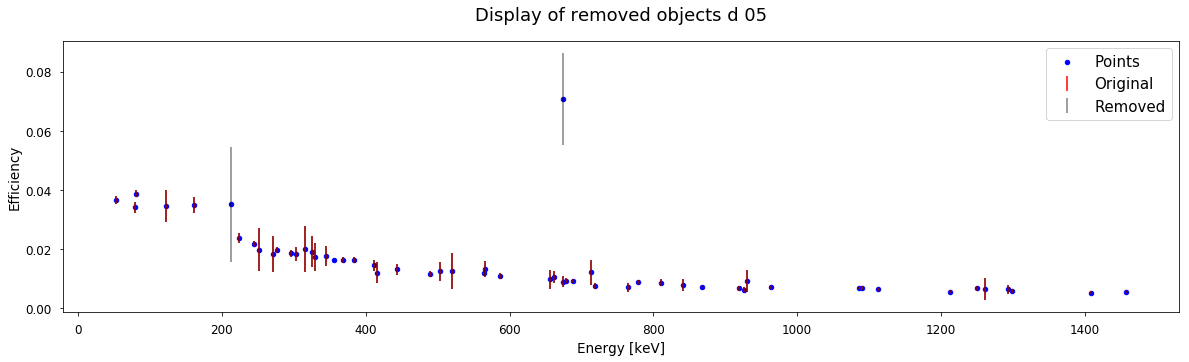

In [19]:
display(d05[d05['efficiency error'] > 0.01])
d05_ = cleanse_(d05, [203,213])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


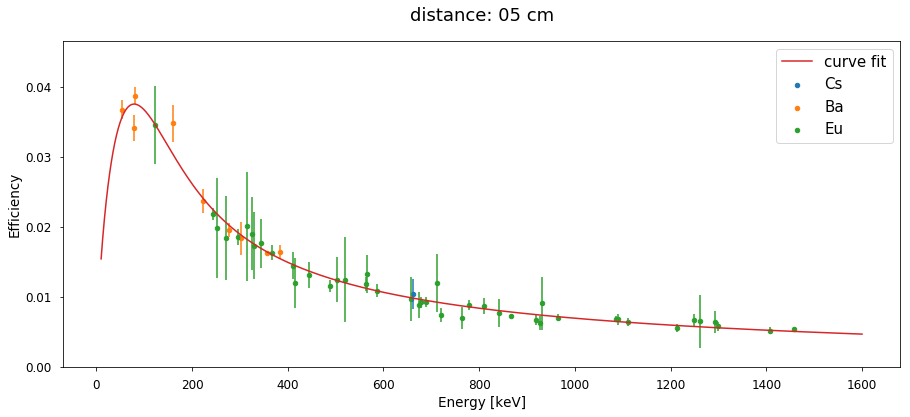

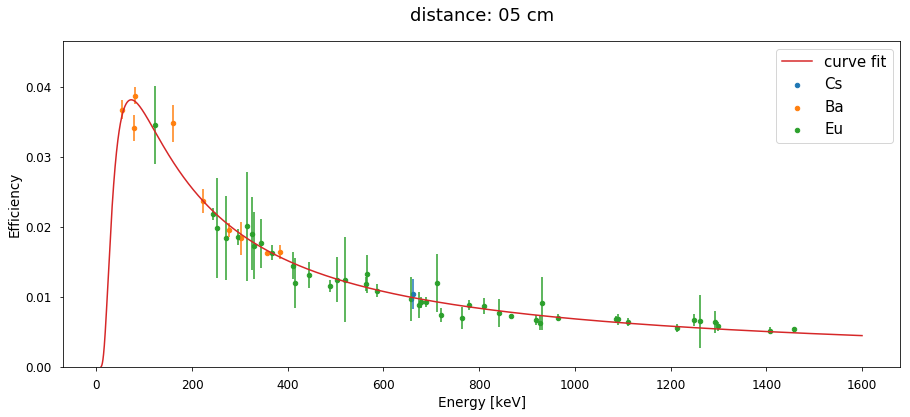

In [20]:
coeff05_2, curve05_2, x05_2 = fitting_Curve(d05_, np.array(([4.953E+109, 2.519E+02, 3.226E-03, 1.706E-03, 1.474E+00])) )  # NICE
coeff05, curve05, x05 = fitting_Curve(d05_, [4.962E+01, 3.795E+01, -8.345E-01, 5.886E-02, -9.821E-01])

In [21]:
def print_(coeff):
    print(f'B0: {coeff[0]:.3E} \nB1: {coeff[1]:.3E} \nB2: {coeff[2]:.3E} \nB3: {coeff[3]:.3E} \nB4: {coeff[4]:.3E}')

print_(coeff05)


B0: 6.072E+01 
B1: 1.480E+02 
B2: -1.231E+00 
B3: 7.201E-02 
B4: -9.294E-01


# D10

The only evident diviations are in the Europium section:

When we see a low intensity high count, it is probablie due to contamination from the background 

| __Energy [keV]__  | __Contamination reason__  |  
|---|---|
|  315.2 |  Low intensity, high count rate. Background at 300 and one at 327 |
|  674.7 |  Low intensity, high count rate. Background at 664.8|

,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
150,Eu152,10,315.1,315.2,325.0,42.9,0.000399,0.000044,2737.0,2019-02-01 13:53:00,318217980.0,0.012708,0.005629
157,Eu152,10,675.0,674.7,363.0,35.2,0.000213,0.000017,2737.0,2019-02-01 13:53:00,318217980.0,0.026589,0.009600


List of removed objects: 


Relevant background information


,Energy,Area:
17,295.0,7816.0
18,299.9,1042.0
19,327.8,927.0
20,338.1,3471.0



Removed Object:


sample_ID                         Eu152
distance [cm]                        10
nndc_energy                       315.1
fits_energy                       315.2
Peak_area                           325
Peak_area_unc                      42.9
Intensity                      0.000399
Intensity sigma               4.389e-05
live_time [s]                      2737
date_time           2019-02-01 13:53:00
time_delay [s]              3.18218e+08
efficiency                     0.012708
efficiency error             0.00562895
Name: 150, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


sample_ID                         Eu152
distance [cm]                        10
nndc_energy                         675
fits_energy                       674.7
Peak_area                           363
Peak_area_unc                      35.2
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                      2737
date_time           2019-02-01 13:53:00
time_delay [s]              3.18218e+08
efficiency                    0.0265885
efficiency error             0.00960002
Name: 157, dtype: object

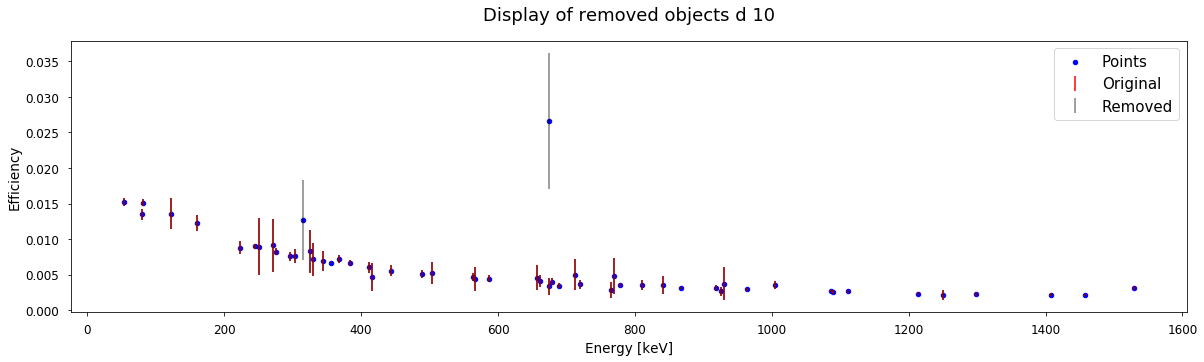

In [22]:
display(d10[d10["efficiency error"] > 0.005])
d10_ = cleanse_(d10, [150,157])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


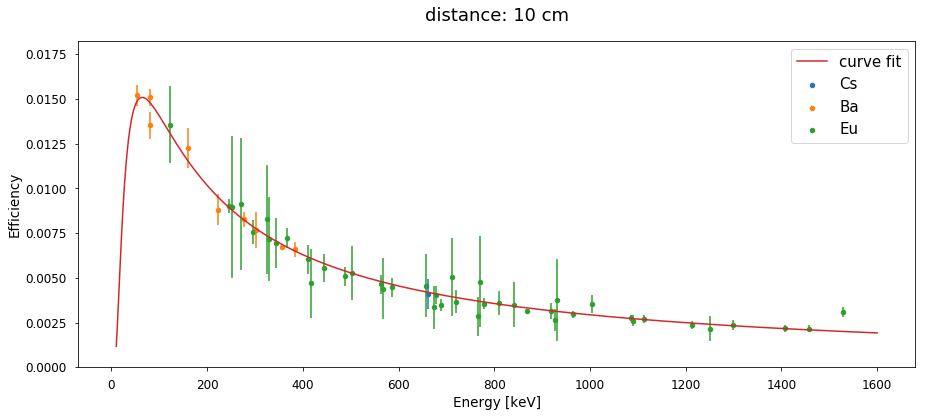

B0: 4.962E+01 
B1: 3.795E+01 
B2: -8.345E-01 
B3: 5.886E-02 
B4: -9.821E-01


In [23]:
#coeff10, curve10, x10 = fitting_Curve(d10_, [0.078e97, 2.15e0, 0.2637, 5.29e-5, 2.33])
#coeff10, curve10, x10 = fitting_Curve(d10_, [8.1e60, 1.4e2, 5.9e-3, 5.29e-3, 1.103])

coeff10, curve10, x10 = fitting_Curve(d10_, [6.107E+01, 3.092E+01, -6.978E-01, 7.319E-02, -1.110E+00])
print_(coeff10)


# d15

The only evident diviations are in the Europium section:

When we see a low intensity high count, it is probablie due to contamination from the background 

| __Energy [keV]__  | __Contamination reason__  |  
|---|---|
|  147.8 |  Low intensity, high count rate. Background at 143.7 |
|  674.7 |  Low intensity, high count rate. Background at 664.8|
|  493.8 |  Low intensity, high count rate. Background at 510.6 and 462.6|

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
16,273,Eu152,15,493.78,493.8,521.0,42.1,0.000098,0.000004,17793.0,2019-02-01 16:35:00,318227700.0,0.012759,0.005397
21,278,Eu152,15,675.00,674.7,1632.0,14.5,0.000213,0.000017,17793.0,2019-02-01 16:35:00,318227700.0,0.018388,0.003049
31,288,Eu152,15,148.00,147.8,857.0,56.4,0.000205,0.000023,17793.0,2019-02-01 16:35:00,318227700.0,0.010033,0.005766


List of removed objects: 


Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


index                               278
sample_ID                         Eu152
distance [cm]                        15
nndc_energy                         675
fits_energy                       674.7
Peak_area                          1632
Peak_area_unc                      14.5
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                     17793
date_time           2019-02-01 16:35:00
time_delay [s]              3.18228e+08
efficiency                    0.0183885
efficiency error             0.00304852
Name: 21, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
9,143.7,1551.0



Removed Object:


index                               288
sample_ID                         Eu152
distance [cm]                        15
nndc_energy                         148
fits_energy                       147.8
Peak_area                           857
Peak_area_unc                      56.4
Intensity                      0.000205
Intensity sigma               2.255e-05
live_time [s]                     17793
date_time           2019-02-01 16:35:00
time_delay [s]              3.18228e+08
efficiency                     0.010033
efficiency error             0.00576576
Name: 31, dtype: object

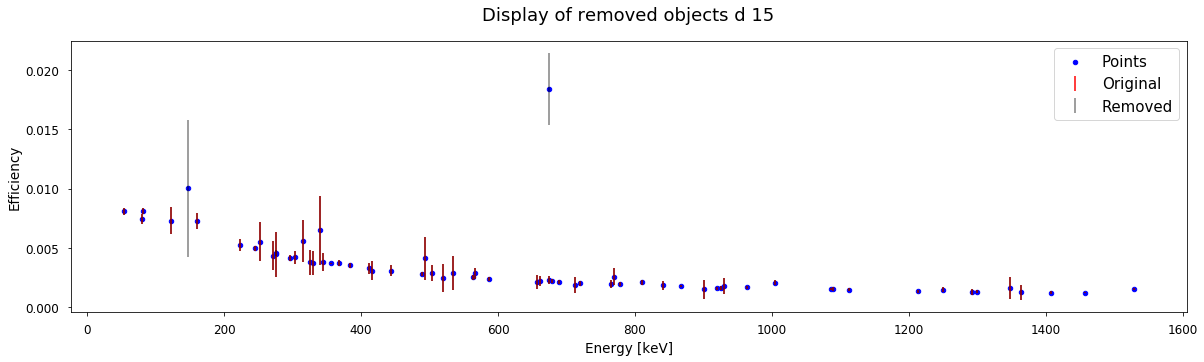

In [24]:
display(d15[d15["efficiency error"] > 0.003])
d15_ = cleanse_(d15, [21,31])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


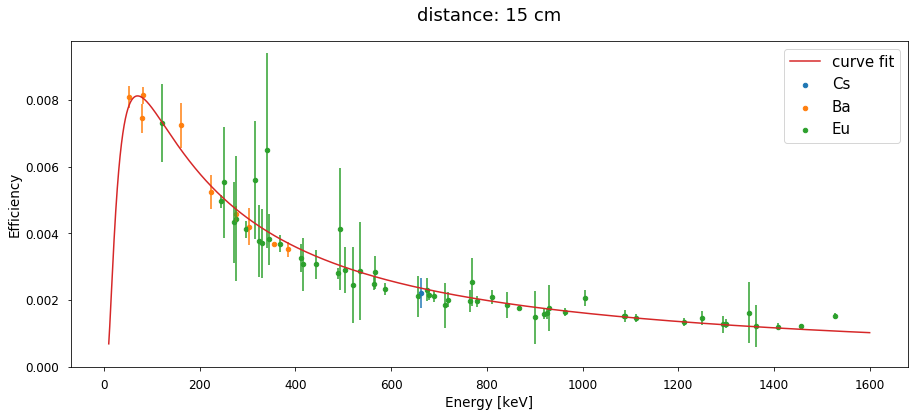

B0: 6.107E+01 
B1: 3.092E+01 
B2: -6.978E-01 
B3: 7.319E-02 
B4: -1.110E+00


In [25]:
#coeff15, curve15, x15 = fitting_Curve(d15_, [1.017E+61, 1.408E+02, 5.514E-03, 6.559E-03, 1.153E+00])
coeff15, curve15, x15 = fitting_Curve(d15_, [4.402E+01, 3.613E+01, -7.667E-01, 5.007E-02, -1.068E+00])
print_(coeff15)


# D18

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
10,61,Eu152,18,315.10,315.5,288.0,54.7,0.000399,0.000044,7048.0,2019-02-04 14:42:00,318480120.0,0.004375,0.002441
11,62,Eu152,18,324.83,325.1,488.0,29.3,0.000731,0.000139,7048.0,2019-02-04 14:42:00,318480120.0,0.004048,0.001414
17,68,Eu152,18,675.00,675.1,528.0,25.0,0.000213,0.000017,7048.0,2019-02-04 14:42:00,318480120.0,0.015025,0.003946


List of removed objects: 


Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


index                                68
sample_ID                         Eu152
distance [cm]                        18
nndc_energy                         675
fits_energy                       675.1
Peak_area                           528
Peak_area_unc                        25
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                      7048
date_time           2019-02-04 14:42:00
time_delay [s]               3.1848e+08
efficiency                    0.0150251
efficiency error             0.00394561
Name: 17, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
18,299.9,1042.0
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                                62
sample_ID                         Eu152
distance [cm]                        18
nndc_energy                      324.83
fits_energy                       325.1
Peak_area                           488
Peak_area_unc                      29.3
Intensity                     0.0007307
Intensity sigma             0.000138833
live_time [s]                      7048
date_time           2019-02-04 14:42:00
time_delay [s]               3.1848e+08
efficiency                   0.00404803
efficiency error             0.00141396
Name: 11, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
17,295.0,7816.0
18,299.9,1042.0
19,327.8,927.0
20,338.1,3471.0



Removed Object:


index                                61
sample_ID                         Eu152
distance [cm]                        18
nndc_energy                       315.1
fits_energy                       315.5
Peak_area                           288
Peak_area_unc                      54.7
Intensity                      0.000399
Intensity sigma               4.389e-05
live_time [s]                      7048
date_time           2019-02-04 14:42:00
time_delay [s]               3.1848e+08
efficiency                   0.00437504
efficiency error             0.00244129
Name: 10, dtype: object

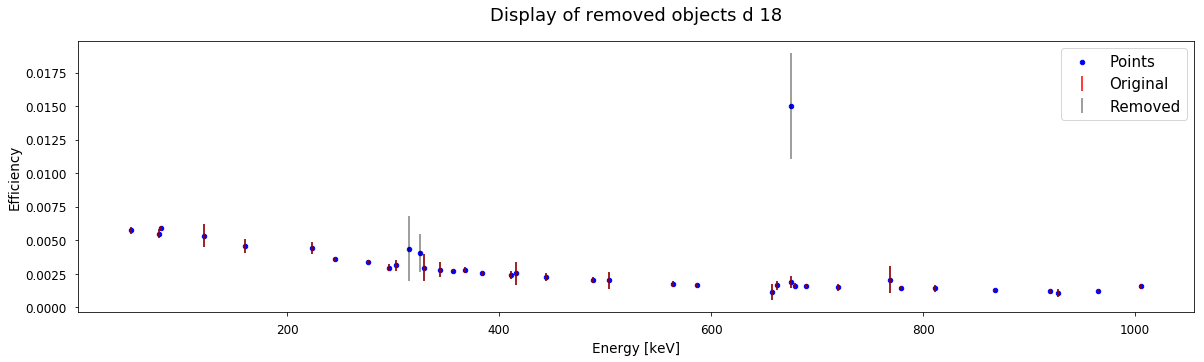

In [26]:
display(d18[d18["efficiency error"] > 0.001])
d18_ = cleanse_(d18, [17,11,10])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


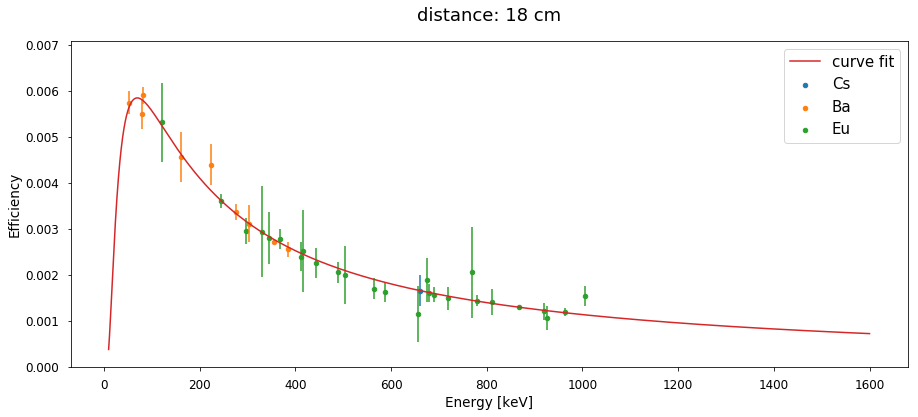

B0: 4.402E+01 
B1: 3.613E+01 
B2: -7.667E-01 
B3: 5.007E-02 
B4: -1.068E+00


In [27]:
#coeff18, curve18, x18 = fitting_Curve(d18_, [0.078, 2.15e0, 0.2637, 5.29e-5, 2.33])
#coeff18, curve18, x18 = fitting_Curve(d18_, [4.977E+61, 1.427E+02 , 5.693E-03, 4.774E-03, 1.182E+00])
coeff18, curve18, x18 = fitting_Curve(d18_, [1.203E+02, 2.399E+01, -5.200E-01, 1.411E-01, -1.341E+00])

print_(coeff18)


## 3.3 Distance 22-60 cm

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
12,92,Eu152,22,351.66,352.2,418.0,36.3,0.000106,0.000008,9038.0,2019-02-05 12:16:00,318557760.0,0.018642,0.006931
17,97,Eu152,22,675.00,675.1,395.0,33.4,0.000213,0.000017,9038.0,2019-02-05 12:16:00,318557760.0,0.008767,0.003012
29,109,Eu152,22,609.23,609.7,578.0,24.4,0.000012,0.000002,9038.0,2019-02-05 12:16:00,318557760.0,0.223965,0.065371


List of removed objects: 


Relevant background information


,Energy,Area:
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                                92
sample_ID                         Eu152
distance [cm]                        22
nndc_energy                      351.66
fits_energy                       352.2
Peak_area                           418
Peak_area_unc                      36.3
Intensity                      0.000106
Intensity sigma                8.48e-06
live_time [s]                      9038
date_time           2019-02-05 12:16:00
time_delay [s]              3.18558e+08
efficiency                    0.0186416
efficiency error             0.00693076
Name: 12, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


index                                97
sample_ID                         Eu152
distance [cm]                        22
nndc_energy                         675
fits_energy                       675.1
Peak_area                           395
Peak_area_unc                      33.4
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                      9038
date_time           2019-02-05 12:16:00
time_delay [s]              3.18558e+08
efficiency                   0.00876656
efficiency error             0.00301161
Name: 17, dtype: object

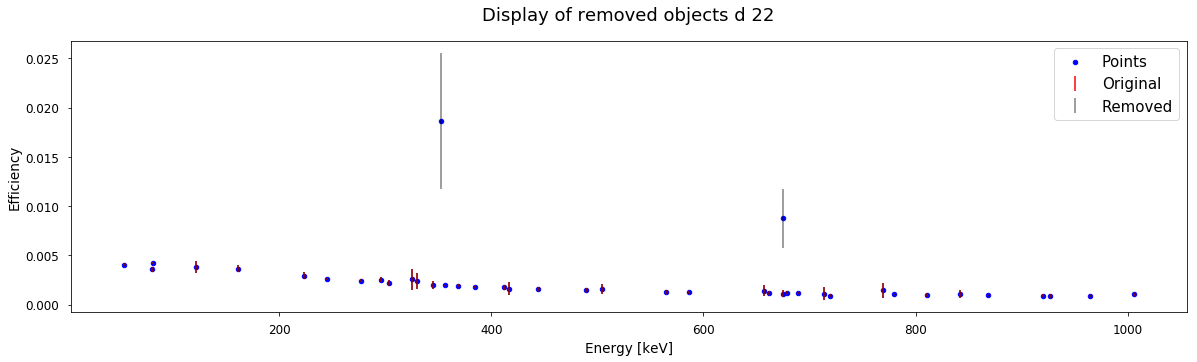

In [28]:
display(d22[d22["efficiency error"] > 0.003])
d22_ = cleanse_(d22, [12,17])


/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


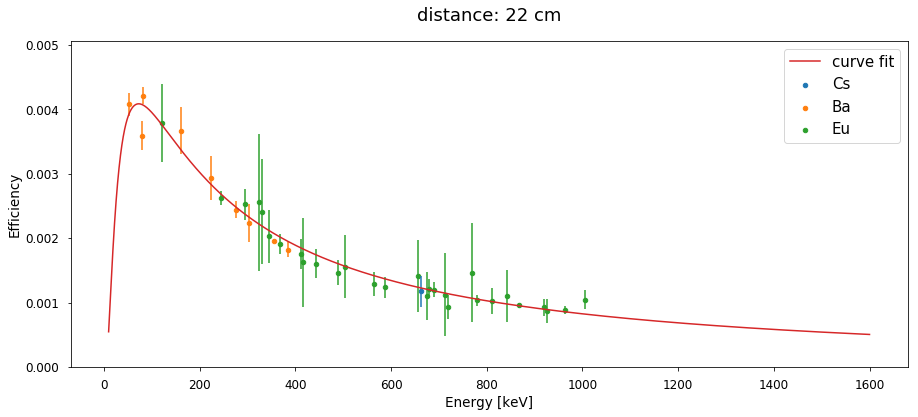

B0: 1.203E+02 
B1: 2.399E+01 
B2: -5.200E-01 
B3: 1.411E-01 
B4: -1.341E+00


In [29]:
#coeff22, curve22, x22 = fitting_Curve(d22_, np.array([3.683E+81, 1.889E+02, 4.258E-03, 4.268E-03, 1.231E+00]))
coeff22, curve22, x22 = fitting_Curve(d22_, np.array([4.474E+04 , 2.721E+01, -2.303E-01, 3.236E+01, -2.359E+00]))

print_(coeff22)


# d 30

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
13,3,Eu152,30,351.66,352.1,851.0,20.0,0.000106,8.480000e-06,15041.0,2019-02-05 15:01:00,318567660.0,0.022806,0.004916
18,8,Eu152,30,675.00,674.9,531.0,25.8,0.000213,1.704000e-05,15041.0,2019-02-05 15:01:00,318567660.0,0.007082,0.001914
23,13,Eu152,30,239.33,238.8,730.0,29.0,0.000030,9.000000e-07,15041.0,2019-02-05 15:01:00,318567660.0,0.069122,0.020159
32,22,Eu152,30,609.23,609.7,847.0,18.9,0.000012,1.952000e-06,15041.0,2019-02-05 15:01:00,318567660.0,0.197215,0.048860


List of removed objects: 


Relevant background information


,Energy,Area:
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                                 3
sample_ID                         Eu152
distance [cm]                        30
nndc_energy                      351.66
fits_energy                       352.1
Peak_area                           851
Peak_area_unc                        20
Intensity                      0.000106
Intensity sigma                8.48e-06
live_time [s]                     15041
date_time           2019-02-05 15:01:00
time_delay [s]              3.18568e+08
efficiency                    0.0228055
efficiency error              0.0049156
Name: 13, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


index                                 8
sample_ID                         Eu152
distance [cm]                        30
nndc_energy                         675
fits_energy                       674.9
Peak_area                           531
Peak_area_unc                      25.8
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                     15041
date_time           2019-02-05 15:01:00
time_delay [s]              3.18568e+08
efficiency                    0.0070816
efficiency error             0.00191365
Name: 18, dtype: object

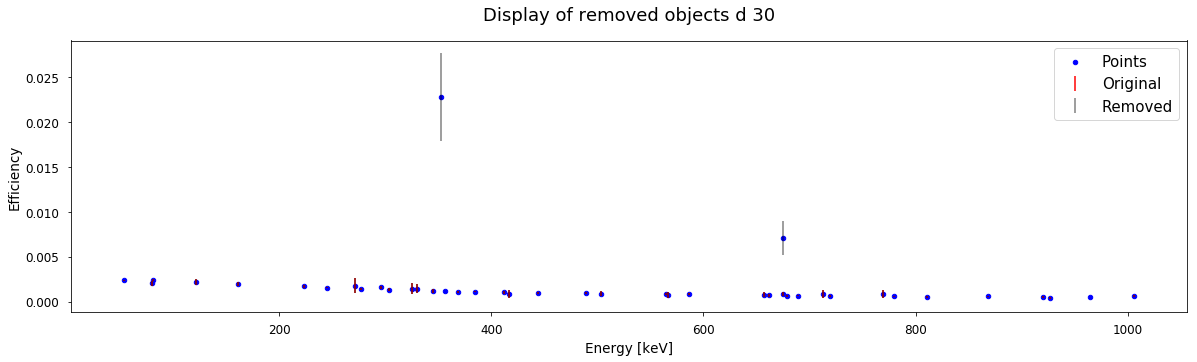

In [30]:
display(d30[d30["efficiency error"] > 0.001])
d30_ = cleanse_(d30, [13,18])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


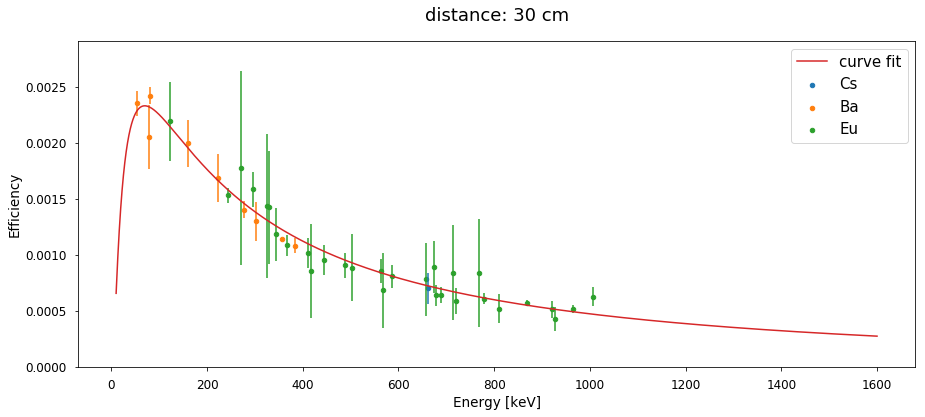

B0: 4.474E+04 
B1: 2.721E+01 
B2: -2.303E-01 
B3: 3.236E+01 
B4: -2.359E+00


In [31]:
#coeff30, curve30, x30 = fitting_Curve(d30_, np.array([1.423E+101, 2.342E+02, 3.544E-03, 3.324E-03, 1.252E+00]))
coeff30, curve30, x30 = fitting_Curve(d30_, np.array([4.686E+04, 2.824E+01, -2.296E-01, 3.745E+01, -2.437E+00]))
print_(coeff30)


# D 40

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
11,35,Eu152,40,328.764,329.2,588.0,29.8,0.000035,7.266000e-06,28294.0,2019-02-08 09:58:00,318808680.0,0.025673,0.009361
13,37,Eu152,40,351.660,351.7,1786.0,11.1,0.000106,8.480000e-06,28294.0,2019-02-08 09:58:00,318808680.0,0.025454,0.003488
17,41,Eu152,40,563.100,563.6,1503.0,11.9,0.000003,6.300000e-07,28294.0,2019-02-08 09:58:00,318808680.0,0.756853,0.182777
30,54,Eu152,40,609.230,608.9,1750.0,10.1,0.000012,1.952000e-06,28294.0,2019-02-08 09:58:00,318808680.0,0.216697,0.041035
35,59,Eu152,40,963.367,963.2,28948.0,1.4,0.001400,8.400000e-05,28294.0,2019-02-08 09:58:00,318808680.0,0.031237,0.001940
36,60,Eu152,40,1084.380,1084.9,18269.0,1.6,0.000106,8.480000e-06,28294.0,2019-02-08 09:58:00,318808680.0,0.260365,0.021336


List of removed objects: 


Relevant background information


,Energy,Area:



Removed Object:


index                                60
sample_ID                         Eu152
distance [cm]                        40
nndc_energy                     1084.38
fits_energy                      1084.9
Peak_area                         18269
Peak_area_unc                       1.6
Intensity                      0.000106
Intensity sigma                8.48e-06
live_time [s]                     28294
date_time           2019-02-08 09:58:00
time_delay [s]              3.18809e+08
efficiency                     0.260365
efficiency error              0.0213362
Name: 36, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
36,933.4,985.0
37,963.9,1273.0
38,968.1,3830.0



Removed Object:


index                                59
sample_ID                         Eu152
distance [cm]                        40
nndc_energy                     963.367
fits_energy                       963.2
Peak_area                         28948
Peak_area_unc                       1.4
Intensity                        0.0014
Intensity sigma                 8.4e-05
live_time [s]                     28294
date_time           2019-02-08 09:58:00
time_delay [s]              3.18809e+08
efficiency                    0.0312366
efficiency error             0.00193953
Name: 35, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                                37
sample_ID                         Eu152
distance [cm]                        40
nndc_energy                      351.66
fits_energy                       351.7
Peak_area                          1786
Peak_area_unc                      11.1
Intensity                      0.000106
Intensity sigma                8.48e-06
live_time [s]                     28294
date_time           2019-02-08 09:58:00
time_delay [s]              3.18809e+08
efficiency                    0.0254536
efficiency error              0.0034882
Name: 13, dtype: object

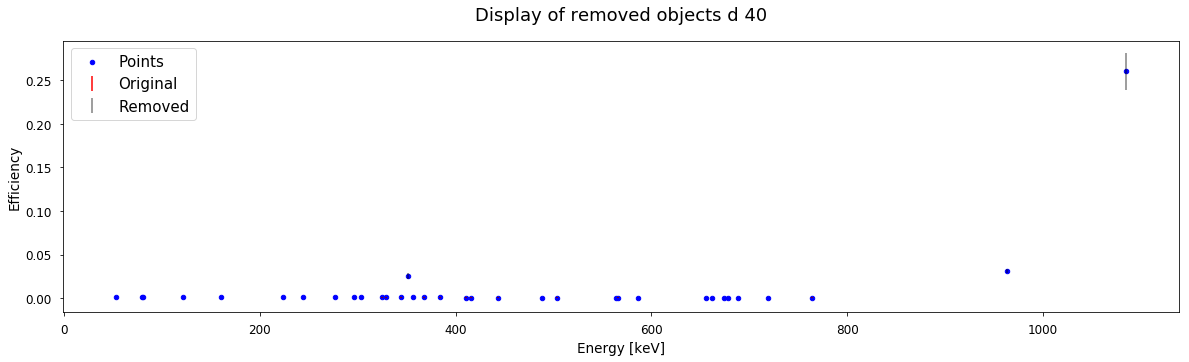

In [32]:
display(d40[d40["efficiency error"] > 0.001])
d40_ = cleanse_(d40, [ 36,35, 13])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


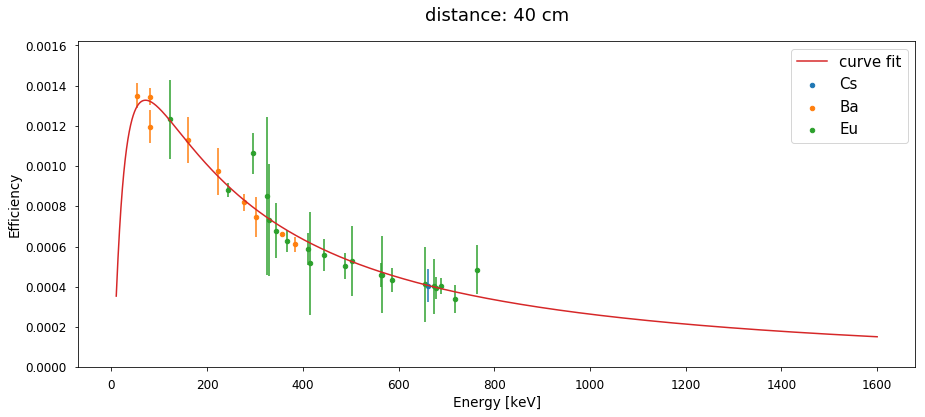

B0: 4.686E+04 
B1: 2.824E+01 
B2: -2.296E-01 
B3: 3.745E+01 
B4: -2.437E+00


In [33]:
coeff40, curve40, x40 = fitting_Curve(d40_, np.array([4.680E+03, 2.492E+01, -2.693E-01, 5.460E+00, -2.165E+00]))
print_(coeff40)

# D 50

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
10,240,Eu152,50,271.08,271.3,868.0,31.6,0.000715,1.358500e-04,64651.0,2019-02-06 16:39:00,318659940.0,0.000802,0.000296
11,241,Eu152,50,324.83,325.1,545.0,42.2,0.000731,1.388330e-04,64651.0,2019-02-06 16:39:00,318659940.0,0.000493,0.000228
13,243,Eu152,50,351.66,352.2,3505.0,7.2,0.000106,8.480000e-06,64651.0,2019-02-06 16:39:00,318659940.0,0.021857,0.002358
18,248,Eu152,50,675.00,675.3,607.0,29.4,0.000213,1.704000e-05,64651.0,2019-02-06 16:39:00,318659940.0,0.001884,0.000574
22,252,Eu152,50,239.33,238.8,3138.0,10.0,0.000030,9.000000e-07,64651.0,2019-02-06 16:39:00,318659940.0,0.069140,0.007238
25,255,Eu152,50,329.41,329.6,892.0,26.0,0.001213,2.911200e-04,64651.0,2019-02-06 16:39:00,318659940.0,0.000486,0.000172
26,256,Eu152,50,416.02,416.4,758.0,27.2,0.001088,2.067200e-04,64651.0,2019-02-06 16:39:00,318659940.0,0.000461,0.000153
30,260,Eu152,50,609.23,609.8,3599.0,6.1,0.000012,1.952000e-06,64651.0,2019-02-06 16:39:00,318659940.0,0.194995,0.033423
33,263,Eu152,50,728.04,727.9,568.0,32.1,0.000111,4.440000e-06,64651.0,2019-02-06 16:39:00,318659940.0,0.003382,0.001094
34,264,Eu152,50,768.96,769.3,708.0,27.0,0.000820,3.280000e-05,64651.0,2019-02-06 16:39:00,318659940.0,0.000571,0.000156


List of removed objects: 


Relevant background information


,Energy,Area:
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                               243
sample_ID                         Eu152
distance [cm]                        50
nndc_energy                      351.66
fits_energy                       352.2
Peak_area                          3505
Peak_area_unc                       7.2
Intensity                      0.000106
Intensity sigma                8.48e-06
live_time [s]                     64651
date_time           2019-02-06 16:39:00
time_delay [s]               3.1866e+08
efficiency                    0.0218566
efficiency error             0.00235843
Name: 13, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


index                               248
sample_ID                         Eu152
distance [cm]                        50
nndc_energy                         675
fits_energy                       675.3
Peak_area                           607
Peak_area_unc                      29.4
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                     64651
date_time           2019-02-06 16:39:00
time_delay [s]               3.1866e+08
efficiency                   0.00188369
efficiency error            0.000574125
Name: 18, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
29,726.7,1790.0



Removed Object:


index                               263
sample_ID                         Eu152
distance [cm]                        50
nndc_energy                      728.04
fits_energy                       727.9
Peak_area                           568
Peak_area_unc                      32.1
Intensity                      0.000111
Intensity sigma                4.44e-06
live_time [s]                     64651
date_time           2019-02-06 16:39:00
time_delay [s]               3.1866e+08
efficiency                   0.00338241
efficiency error             0.00109446
Name: 33, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
14,241.6,3555.0
15,270.1,1130.0
16,277.4,713.0
17,295.0,7816.0
18,299.9,1042.0



Removed Object:


index                               240
sample_ID                         Eu152
distance [cm]                        50
nndc_energy                      271.08
fits_energy                       271.3
Peak_area                           868
Peak_area_unc                      31.6
Intensity                      0.000715
Intensity sigma              0.00013585
live_time [s]                     64651
date_time           2019-02-06 16:39:00
time_delay [s]               3.1866e+08
efficiency                  0.000802443
efficiency error            0.000295943
Name: 10, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
18,299.9,1042.0
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                               241
sample_ID                         Eu152
distance [cm]                        50
nndc_energy                      324.83
fits_energy                       325.1
Peak_area                           545
Peak_area_unc                      42.2
Intensity                     0.0007307
Intensity sigma             0.000138833
live_time [s]                     64651
date_time           2019-02-06 16:39:00
time_delay [s]               3.1866e+08
efficiency                  0.000493013
efficiency error            0.000228198
Name: 11, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
30,767.7,1356.0
31,785.3,488.0
32,794.2,1142.0



Removed Object:


index                               264
sample_ID                         Eu152
distance [cm]                        50
nndc_energy                      768.96
fits_energy                       769.3
Peak_area                           708
Peak_area_unc                        27
Intensity                       0.00082
Intensity sigma                3.28e-05
live_time [s]                     64651
date_time           2019-02-06 16:39:00
time_delay [s]               3.1866e+08
efficiency                  0.000570716
efficiency error            0.000155837
Name: 34, dtype: object

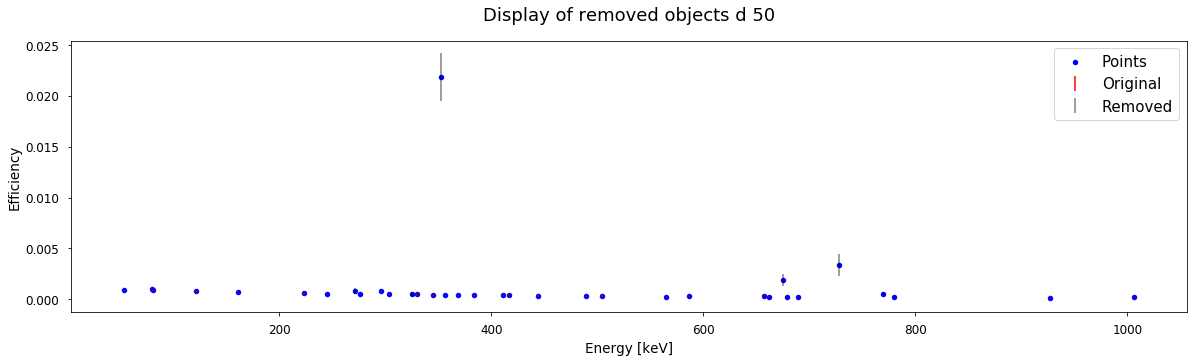

In [34]:
display(d50[d50["efficiency error"] > 0.00015])
d50_ = cleanse_(d50, [13,18,33, 10, 11, 34])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


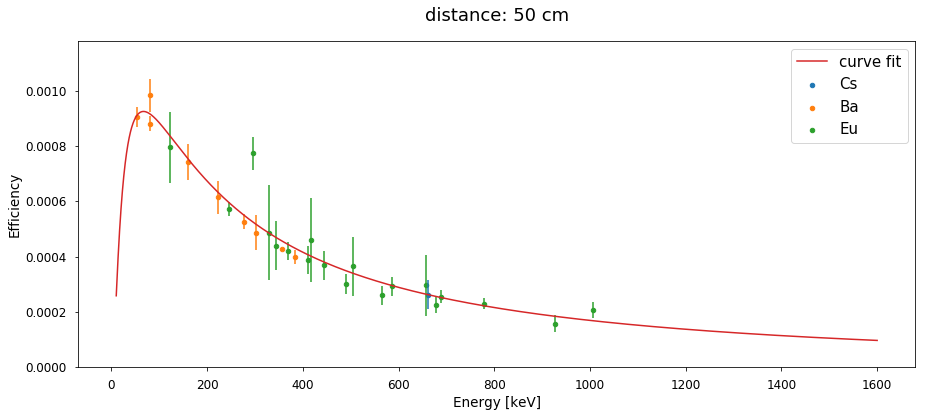

B0: 4.680E+03 
B1: 2.492E+01 
B2: -2.693E-01 
B3: 5.460E+00 
B4: -2.165E+00


In [35]:
#coeff50, curve50, x50 = fitting_Curve(d50_, np.array([0.078, 2.15e0, 0.2637, 5.29e-5, 2.33])/5.5e3)
coeff50, curve50, x50 = fitting_Curve(d50_, np.array([4.132E+03, 2.444E+01, -2.644E-01, 4.094E+00, -2.149E+00]))
print_(coeff50)


# D 60

,index,sample_ID,distance [cm],nndc_energy,fits_energy,Peak_area,Peak_area_unc,Intensity,Intensity sigma,live_time [s],date_time,time_delay [s],efficiency,efficiency error
11,123,Eu152,60,351.66,352.2,3141.0,6.8,0.000106,8.480000e-06,55857.0,2019-02-05 19:14:00,318582840.0,0.022667,0.002386
16,128,Eu152,60,675.00,675.3,479.0,31.6,0.000213,1.704000e-05,55857.0,2019-02-05 19:14:00,318582840.0,0.001720,0.000561
19,131,Eu152,60,970.22,969.7,838.0,18.2,0.000012,3.600000e-07,55857.0,2019-02-05 19:14:00,318582840.0,0.053420,0.009862
21,133,Eu152,60,239.33,238.8,3250.0,8.4,0.000030,9.000000e-07,55857.0,2019-02-05 19:14:00,318582840.0,0.082871,0.007419
24,136,Eu152,60,329.41,329.6,481.0,46.9,0.001213,2.911200e-04,55857.0,2019-02-05 19:14:00,318582840.0,0.000303,0.000160
25,137,Eu152,60,416.02,416.4,444.0,38.9,0.001088,2.067200e-04,55857.0,2019-02-05 19:14:00,318582840.0,0.000312,0.000135
29,141,Eu152,60,609.23,609.8,3398.0,6.1,0.000012,1.952000e-06,55857.0,2019-02-05 19:14:00,318582840.0,0.213061,0.036520
32,144,Eu152,60,768.96,769.3,466.0,35.3,0.000820,3.280000e-05,55857.0,2019-02-05 19:14:00,318582840.0,0.000435,0.000154


List of removed objects: 


Relevant background information


,Energy,Area:
19,327.8,927.0
20,338.1,3471.0
21,351.7,14420.0



Removed Object:


index                               123
sample_ID                         Eu152
distance [cm]                        60
nndc_energy                      351.66
fits_energy                       352.2
Peak_area                          3141
Peak_area_unc                       6.8
Intensity                      0.000106
Intensity sigma                8.48e-06
live_time [s]                     55857
date_time           2019-02-05 19:14:00
time_delay [s]              3.18583e+08
efficiency                    0.0226675
efficiency error             0.00238638
Name: 11, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
27,661.3,348.0
28,664.8,472.0



Removed Object:


index                               128
sample_ID                         Eu152
distance [cm]                        60
nndc_energy                         675
fits_energy                       675.3
Peak_area                           479
Peak_area_unc                      31.6
Intensity                      0.000213
Intensity sigma               1.704e-05
live_time [s]                     55857
date_time           2019-02-05 19:14:00
time_delay [s]              3.18583e+08
efficiency                   0.00172027
efficiency error            0.000560912
Name: 16, dtype: object

---------------------------------------------

Relevant background information


,Energy,Area:
30,767.7,1356.0
31,785.3,488.0
32,794.2,1142.0



Removed Object:


index                               144
sample_ID                         Eu152
distance [cm]                        60
nndc_energy                      768.96
fits_energy                       769.3
Peak_area                           466
Peak_area_unc                      35.3
Intensity                       0.00082
Intensity sigma                3.28e-05
live_time [s]                     55857
date_time           2019-02-05 19:14:00
time_delay [s]              3.18583e+08
efficiency                  0.000434723
efficiency error            0.000154476
Name: 32, dtype: object

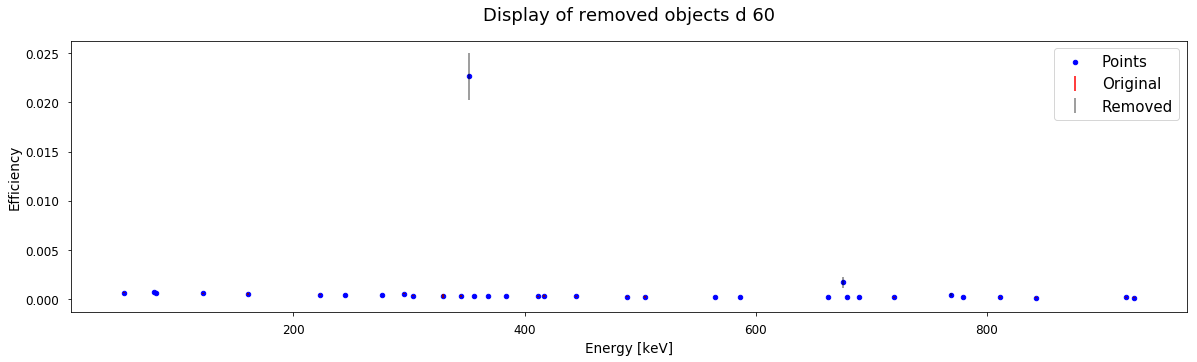

In [36]:
display(d60[d60["efficiency error"] > 0.0001])
d60_ = cleanse_(d60, [11,16,32])

/home/oline/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


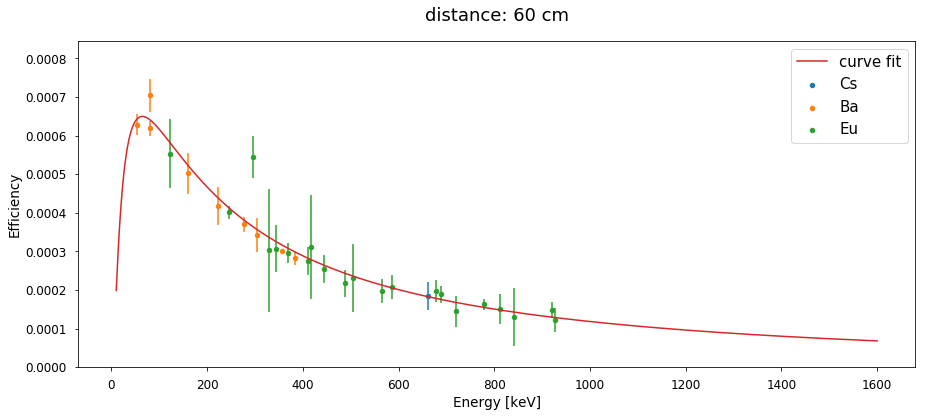

B0: 4.132E+03 
B1: 2.444E+01 
B2: -2.644E-01 
B3: 4.094E+00 
B4: -2.149E+00


In [37]:
#coeff60, curve60, x60 = fitting_Curve(d60_, np.array([0.078, 2.15e0, 0.2637, 5.29e-5, 2.33])/5.56e3)
coeff60, curve60, x60 = fitting_Curve(d60_, np.array([5.050E+03, 2.202E+01, -2.319E-01, 3.420E+00, -2.006E+00]))
print_(coeff60)



## 3.4 Example of how point disrupt the curve-fit of distance 22cm

# 4. Models

/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


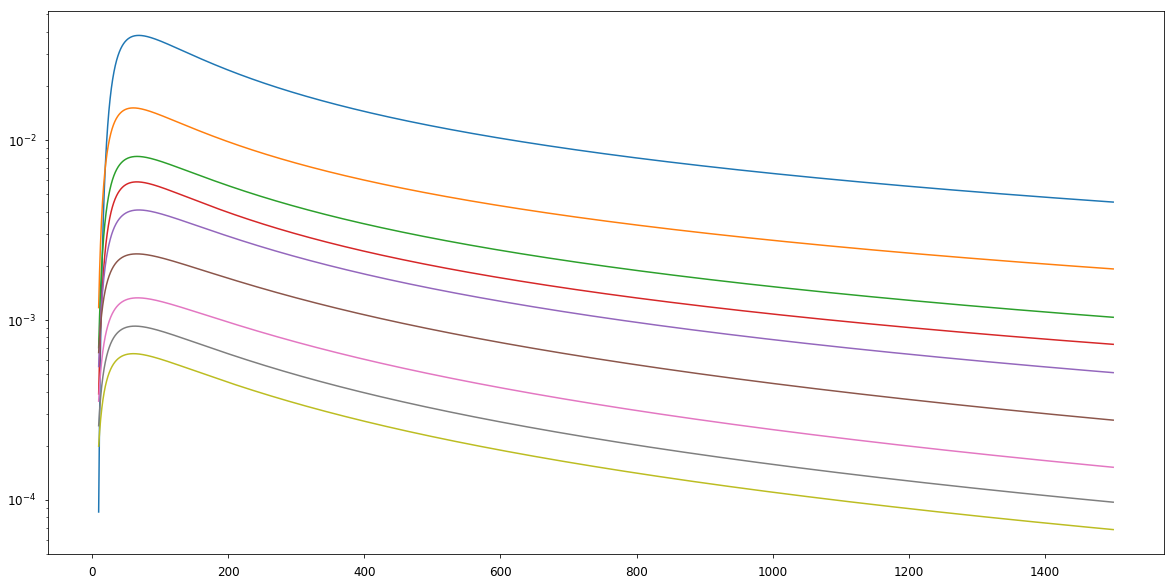

In [38]:
plt.figure(figsize = (20,10))
x = np.linspace(10,1500, 1e4)
plt.semilogy(x, curve05, label = '05')
plt.semilogy(x, curve10, label = '10' )
plt.semilogy(x, curve15, label = '15')
plt.semilogy(x, curve18, label = '18')
plt.semilogy(x, curve22, label = '22')
plt.semilogy(x, curve30, label = '30')
plt.semilogy(x, curve40, label = '40')
plt.semilogy(x, curve50, label = '50')
plt.semilogy(x, curve60, label = '60')
#plt.legend()

/home/oline/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


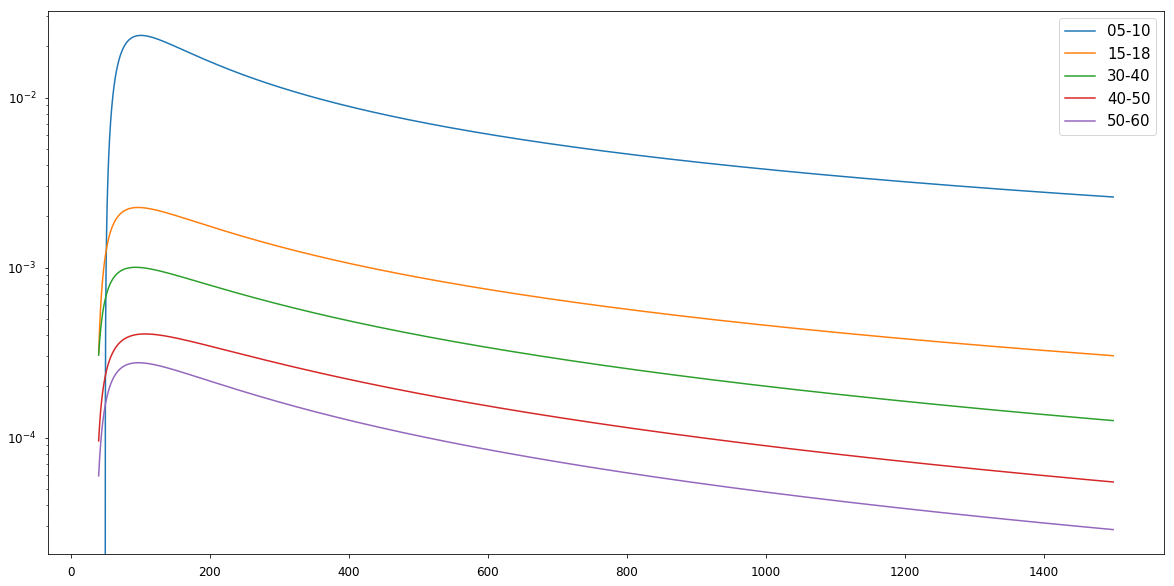

In [39]:
plt.figure(figsize = (20,10))
x = np.linspace(40,1500, 1e4)
plt.semilogy(x, curve05-curve10, label = '05-10')
plt.semilogy(x, curve15-curve18, label = '15-18')
plt.semilogy(x, curve30-curve40, label = '30-40')
plt.semilogy(x, curve40-curve50, label = '40-50')
plt.semilogy(x, curve50-curve60, label = '50-60')
plt.legend()

In [40]:
def models(dist, B):
    print(f'\nModel of d = {dist}:    {B[0]:.2E} * exp[-{B[1]:.3f}E^{B[2]:.3f}] * (1-exp[-{B[3]:.3f}*E^{B[4]:.3f}])\n')
    
models('d05', coeff05)
models('d10', coeff10)
models('d15', coeff15)
models('d18', coeff18)
models('d22', coeff22)
models('d30', coeff30)
models('d40', coeff40)
models('d50', coeff50)
models('d60', coeff60)


Model of d = d05:    6.07E+01 * exp[-148.001E^-1.231] * (1-exp[-0.072*E^-0.929])


Model of d = d10:    4.96E+01 * exp[-37.954E^-0.834] * (1-exp[-0.059*E^-0.982])


Model of d = d15:    6.11E+01 * exp[-30.916E^-0.698] * (1-exp[-0.073*E^-1.110])


Model of d = d18:    4.40E+01 * exp[-36.129E^-0.767] * (1-exp[-0.050*E^-1.068])


Model of d = d22:    1.20E+02 * exp[-23.987E^-0.520] * (1-exp[-0.141*E^-1.341])


Model of d = d30:    4.47E+04 * exp[-27.209E^-0.230] * (1-exp[-32.365*E^-2.359])


Model of d = d40:    4.69E+04 * exp[-28.239E^-0.230] * (1-exp[-37.445*E^-2.437])


Model of d = d50:    4.68E+03 * exp[-24.921E^-0.269] * (1-exp[-5.460*E^-2.165])


Model of d = d60:    4.13E+03 * exp[-24.444E^-0.264] * (1-exp[-4.094*E^-2.149])



In [45]:
np.save('C05_2',coeff05)
np.save('C10_2',coeff05)
np.save('C15_2',coeff05)
np.save('C18_2',coeff18)
np.save('C22_2',coeff22)
np.save('C30_2',coeff30)
np.save('C40_2',coeff40)
np.save('C50_2',coeff50)
np.save('C60_2',coeff60)

# Testing for problems

In [41]:
def test_for_complications(path, sample_type, nndc_E, nndc_I, source_calibration_date = source_calibration_date):
    """ This section is for testing possible problematic overlapp values in the nndc and fitz values
    """
    
    live_time, date_spec, sample, distance = [], [], [], []
    nndcE = []
    fitsE, fitsN, fitsI         = [], [], []
    
    for filename in os.listdir(path):
        with open('Calibration_Reports/' + filename, 'r') as infile:
            
            if filename[11:13] == sample_type:
                lines = infile.readlines()
                print('------------------------------------------\n')
                print(filename[11:21], '\n')
                fitz_energy, fitz_peak_area, unc = investigate(lines[33:])
                
                for j in range(len(fitz_energy)-1):
                    if abs(fitz_energy[j]-fitz_energy[j+1]) < 0.5:
                        print('Problem located at fits E: ', fitz_energy[j])
                for j in range(len(nndc_E)-1):
                    if abs(nndc_E[j]-nndc_E[j+1]) < 0.5:
                        print('Problem located at nndc E: ', nndc_E[j])
                        
                        
#test_for_complications(mypath, 'Eu', EuE, EuI)